# Lab 2 AI for Multimodal Cyberharassment Detection



With previous lab learning, you should have some knowledge about how to develop an AI model to detect cyberbullying lauguage. In this lab, we will keep learning how AI can be developed to detect cyberbullying. We will use a publicly available test dataset of cyberbullying images, and deploy an pre-trained AI model to automatically detect cyberbullying images.
Approach towards analysing the cyber bullying in images in a dataset, there are three steps:
1. Understand and identify the factors related to cyberbullying in images.
2. Deploy the pre-trained AI model.
3. Examine the AI to detect cyberbulling images.

## Download the pre-trained model, test dataset and the dependencies

First, we need to download the pre-trained model and the test dataset used in the lab. Just hit the 'play' button run the code below.

In [1]:
 # @title download the model and dataset
!wget -O auxes_17.pt https://buffalo.box.com/shared/static/cjk39hq7prpwj2rkqz6lc2jr6q2h5shy.pt # model checkpoints
!wget -O cyberbullying_data.zip https://github.com/cuadvancelab/materials/blob/main/lab2/cyberbullying_data.zip?raw=true # test dataset

# unzip the test data
# %%capture
!unzip "/content/cyberbullying_data.zip" -d "/content"

--2025-07-18 18:35:19--  https://buffalo.box.com/shared/static/cjk39hq7prpwj2rkqz6lc2jr6q2h5shy.pt
Resolving buffalo.box.com (buffalo.box.com)... 74.112.186.157, 2620:117:bff0:12d::
Connecting to buffalo.box.com (buffalo.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/cjk39hq7prpwj2rkqz6lc2jr6q2h5shy.pt [following]
--2025-07-18 18:35:19--  https://buffalo.box.com/public/static/cjk39hq7prpwj2rkqz6lc2jr6q2h5shy.pt
Reusing existing connection to buffalo.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://buffalo.app.box.com/public/static/cjk39hq7prpwj2rkqz6lc2jr6q2h5shy.pt [following]
--2025-07-18 18:35:20--  https://buffalo.app.box.com/public/static/cjk39hq7prpwj2rkqz6lc2jr6q2h5shy.pt
Resolving buffalo.app.box.com (buffalo.app.box.com)... 74.112.186.157, 2620:117:bff0:12d::
Connecting to buffalo.app.box.com (buffalo.app.box.com)|74.112.186.157|:443... connected.
HTTP

In [2]:
# @title Let's import all our softwares dependencies in our iPython notebook

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch.utils.data as data_utils
import torchvision.transforms as transforms
from torchvision import models
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import pickle
import gzip
import sys
import time
import numpy as np
import math
import os
import random
from skimage import io, transform

## Load datasets

In [3]:
# @title Now, let's run the subsequent codes to load your data from a predefined dataset class.
class PosesDataset(Dataset):

  def __init__(self, root_dir, poses_dir, auxes_dir):

    self.samples = []
    self.root_dir = root_dir
    self.poses_dir = poses_dir
    self.auxes_dir = auxes_dir

    for _, _, cb_images in os.walk(self.root_dir + 'cyberbullying'): break
    for _, _, non_cb_images in os.walk(self.root_dir + 'non_cyberbullying'): break
    for _, _, cb_poses in os.walk(self.poses_dir + 'cyberbullying'): break
    for _, _, non_cb_poses in os.walk(self.poses_dir + 'non_cyberbullying'): break

    for i in cb_images:
      self.samples.append((self.root_dir + 'cyberbullying/' + i, self.poses_dir + 'cyberbullying/' + i, self.auxes_dir + 'cyberbullying/' + i, 1))

    for i in non_cb_images:
      self.samples.append((self.root_dir + 'non_cyberbullying/' + i, self.poses_dir + 'non_cyberbullying/' + i, self.auxes_dir + 'non_cyberbullying/' + i, 0))


  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    img_name, pose_name, aux_name, label = self.samples[idx]
    image = io.imread(img_name)

    aux = pickle.load(open(aux_name + '.p', 'rb'))
    aux = torch.tensor(aux)

    # drop the alpha channel for some images
    if image.shape == (224, 224):
      # handle grayscale images
      image = np.stack([image, image, image], axis=2)

    if image.shape == (224, 224, 4):
      image = image[:,:,:3]

    image = image.transpose((2, 0, 1)) # C X H X W
    pose = io.imread(pose_name)
    if pose.shape != (224, 224):
      pose = pose[:,:,0]
    pose = np.expand_dims(pose, axis = 0)
    image = np.concatenate((image, pose), axis = 0)
    sample = {'image': torch.from_numpy(image.copy()).float() / 255, 'aux': aux, 'label': label}
    return sample

In [4]:
# @title Load the model and dataset
valid_set = PosesDataset('cyberbullying_data/cyberbullying_data_splits_clean/test/', 'cyberbullying_data/cyberbullying_poses/test/', 'cyberbullying_data/cyberbullying_data_auxes/test/')
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = 1, shuffle = True)

## How to identify cyberbullying in images

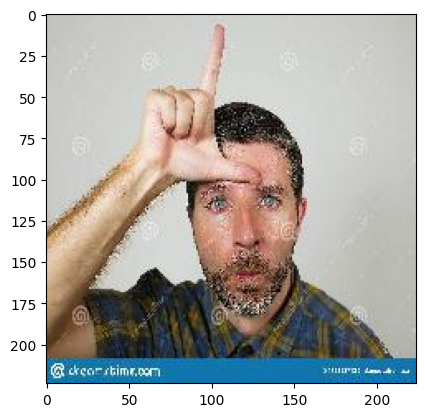

In [5]:
# @title An example image
# importing required libraries
import matplotlib.pyplot as plt
import matplotlib.image as img

# reading the image
testImage = img.imread('/content/cyberbullying_data/cyberbullying_data_splits_clean/test/cyberbullying/7.s-s-unshaven-sad-ashamed-man-doing-loser-sign-hand-fingers-his-front-funny-depressed-face-expression-s-139158713.jpg')

# displaying the image
plt.imshow(testImage)

**5 FACTORS to measurement cyberbulling in images**
- Body-pose
- Facial Emotion
- Object
- Gesture
- Social Factors

<img src="https://github.com/cuadvancelab/materials/blob/main/lab2/factors.png?raw=true" alt="drawing" width="600"/>



- - - -
**<font color='red'>QUESTION 1:</font>
Do you think there are any other factors that could help us identify cyberbullying in images?**
- - - -

The follow table shows the analysis of cyberbulling factors in images. Higher value below indicates higher correlation.

| Factor        | Attribute           |  Cyberbulling  |  Non-cyberbulling  |  Description  |
| ------------- |:----------:|:-----:|:-----:| ------------- :|
| Body-pose      | Front pose <br> Non-front pose | 0.86<br>0.50 | 0.53 <br> 0.84 | Pose of subject in image is towards the viewer |
| Emotion      | Joy <br> Sorrow <br> Anger <br> Surprise | 0.34<br>0.02<br>0.09<br>0.07 | 0.25<br>0.02<br>0.04<br>0.05 | Facial emotion of subject in image|
| Gesture      | Hand gesture <br> No hand gesture | 0.71<br>0.70 | 0.32 <br> 0.94 | Hand gesture made by subject in imager |
| Object      | Threatening object <br> No threatening object | 0.33<br>0.94 | 0.06 <br> 0.99 | Threatening object present in image |
| Social      | Anti-LGBT <br> Anti-black racism | 0.45<br>0.03 | 0.06 <br> 0.00 | Anti-LGBT symbols and anti-black racism in image |



- - - -
**<font color='red'>QUESTION 2:</font>
What can you observe from the above table?**
- - - -

## Load our pre-trained AI model

For our AI model, it will consider both the low level image features and the cyberbulling factors identified before together to make prediction.

The AI model prediction process looks like the following figure.
<img src="https://github.com/cuadvancelab/materials/blob/main/lab2/model.png?raw=true" alt="drawing" width="700"/>

In our AI model, we combine the low level image features with the cyberbulling factors identified before. We combine these features using feature fusion techniques.

We use a pre-trained `CNN` model for image features  and use a multi-layer perceptron model `MLP` for the factors related features, and combine the feature vectors from both these models using late fusion.




- - - -
**<font color='red'>QUESTION 3:</font>
Do you remember the AI we used when detecting cyberbullying text? <br> Similar with the image factors, what is the factor which can help AI detect cyberbulling text?**
- - - -

In [6]:
# @title Load an AI model
orig = models.vgg16(pretrained = True)

class CB(nn.Module):
  def __init__(self):
    super(CB, self).__init__()
    self.conv1 = nn.Conv2d(4, 3, 1)
    self.f = nn.Sequential(*list(orig.features.children()))
    self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
    self.aux_classifier = nn.Sequential(
      nn.Linear(25097, 1024),
      nn.ReLU(),
      nn.Linear(1024, 25088),
      nn.ReLU()
    )
    self.classifier = nn.Sequential(*list(orig.classifier.children()))
    self.classifier[-1] = nn.Linear(4096, 2)
    self.sig = nn.Sigmoid()

  def forward(self, x, aux):
    x = self.conv1(x)
    x = self.f(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = torch.cat((x, aux), dim = 1)
    x = self.aux_classifier(x)
    x = self.classifier(x)
    x = self.sig(x)


    return x

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 91.8MB/s]


In [7]:
# @title Use the GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
# @title Pass the pre-trained checkpoints to the model so that you can have our pre-trained model
model = torch.load("auxes_17.pt", weights_only=False)
model.to(device)

criterion = nn.CrossEntropyLoss()

running_loss = []
correct, incorrect, total = 0., 0., 0.

## Generate the detection resuls for validation data

Now, it's time to evaulate the pre-trained model's capability with our test dataset

In [9]:
# @title Run the model on the validation dataset

with torch.no_grad():
  for i_v, data_v in enumerate(valid_loader):
    x_valid, y_valid, aux_valid = data_v['image'], data_v['label'], data_v['aux']
    x_valid, y_valid, aux_valid = x_valid.to(device), y_valid.to(device, dtype = torch.long), aux_valid.to(device, dtype = torch.float)
    y_valid_ = model(x_valid, aux_valid)
    running_loss.append(criterion(y_valid_, y_valid))
    _, predicted = torch.max(y_valid_.data, 1)
    total += y_valid.size(0)
    correct += (predicted == y_valid).sum().item()

print('Val loss is: {:.3f}'.format((sum(running_loss) / len(running_loss)).item()))
print('The accuracy for validation dataset is: {}%'.format((correct / total) * 100))

Val loss is: 0.449
The accuracy for validation dataset is: 85.0%



- - - -
**<font color='red'>QUESTION 4:</font>
How well does your model perform, and what is the accuracy of the validation dataset?**
- - - -

In Machine Learning, besides Accuracy (# Correct prediction / # Total prediction), we have different metrics for evaluating results, such as <br>

**True Positive (TP):**<br>
A true positive is an outcome where the model correctly predicts the positive class (labeled as cyberbullying).

**True Negative (TN):**<br>
A true negative is an outcome where the model correctly predicts the negative class (labeled as non-cyberbullying).

**False Positive (FP):**<br>
A false positive is an outcome where the model incorrectly predicts the positive class.

**False Negative (FN):**<br>
And a false negative is an outcome where the model incorrectly predicts the negative class.

In [10]:
# @title Now, let's utilize the new metrics to evaluate the model
TP, TN, FP, FN = 0, 0, 0, 0
with torch.no_grad():
    for i_v, data_v in enumerate(valid_loader):
        x_valid, y_valid, aux_valid = data_v['image'], data_v['label'], data_v['aux']
        x_valid, y_valid, aux_valid = x_valid.to(device), y_valid.to(device, dtype = torch.long), aux_valid.to(device, dtype = torch.float)
        y_valid_ = model(x_valid, aux_valid)
        _, predicted = torch.max(y_valid_.data, 1)
        if y_valid == 1 and predicted == 1:
            TP += 1
        elif y_valid == 0 and predicted == 0:
            TN += 1
        elif y_valid == 0 and predicted == 1:
            FP += 1
        elif y_valid == 1 and predicted == 0:
            FN += 1

print('We have {} testing samples. Among them we have:'.format(len(valid_loader)))
print('True Positives: {}, True Negatives: {}, False Positives: {}, False Negatives: {}'.format(TP, TN, FP, FN))

We have 20 testing samples. Among them we have:
True Positives: 8, True Negatives: 9, False Positives: 1, False Negatives: 2



- - - -
**<font color='red'>QUESTION 5:</font>
Can you interpret False Positives for cyberbullying detection tasks? Is it meaningful to discuss false-positive samples? Why?**
- - - -

### Let's check with one instance

To better understand the performance, let us visualize one instance in the dataset

In [11]:
# @title Check how many test data samples we have
print(f"we have {len(valid_set)} samples in our test dataset, you can choose any of them to see the prediction.")

we have 20 samples in our test dataset, you can choose any of them to see the prediction.


You can simply change the number in next cell to select different sample

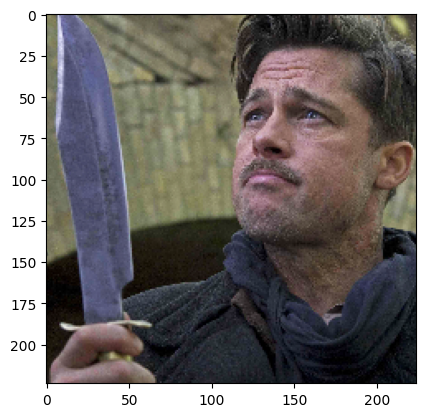


The label of this image is: cyberbullying


In [12]:
#@markdown Select an index number to view the image and its label.

picture_index  = "5" #@param [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
index = int(picture_index)
instance = valid_set[index]

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(valid_set.samples[index][0])
imgplot = plt.imshow(img)
plt.show()
annot_label = "cyberbullying" if valid_set[index]['label']==1 else "non-cyberbullying"
print('')
print("The label of this image is: {}".format(annot_label))

Run the following code cell to check the AI's prediction

In [13]:
# @title Now, let's check if the prediction is correct
instance_image, instance_label, instance_aux = instance['image'].to(device), torch.tensor(instance['label']).to(device, dtype = torch.long), instance['aux'].to(device, dtype = torch.float)

output = model(instance_image.unsqueeze(0), instance_aux.unsqueeze(0)).data
_, prediction = torch.max(output.data, 1)
predict_label = "cyberbullying" if prediction.item()==1 else "non-cyberbullying"
comparision = "correct" if prediction==instance_label else "not correct"

print("The AI prediction for this image is: {}, which is {}!".format(predict_label, comparision))

The AI prediction for this image is: cyberbullying, which is correct!


## Discussion



- - - -
**<font color='red'>QUESTION 6:</font>
According to lab1 and lab2, what do think about the AIs? Are there other real-world problems that could benefit from artificial intelligence?**
- - - -